In [2]:
# Import libraries
import os
import re
import nltk
import pickle
import urllib
import string
import sqlite3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
warnings.filterwarnings("ignore")

color = sns.color_palette()

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
total = train_df.isnull().sum().sort_values(ascending=False)
p_1 = train_df.isnull().sum()/train_df.isnull().count()*100
p_2 = (round(p_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, p_2], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0
Parch,0,0.0
SibSp,0,0.0
Sex,0,0.0
Name,0,0.0
Pclass,0,0.0


In [17]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

Age vs Sex

Text(0.5, 1.0, 'Male')

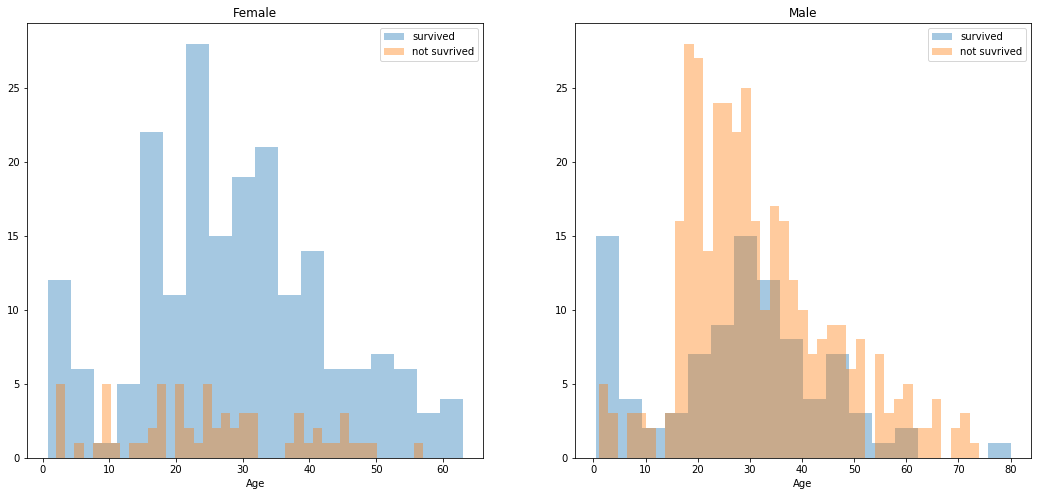

In [39]:
survived = 'survived'
not_survived = 'not suvrived'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

men = train_df[train_df['Sex']=='male']
women = train_df[train_df['Sex']=='female']

ax = sns.distplot((women[women['Survived'] == 1]).Age.dropna(), bins=18, label=survived, ax=axes[0], kde=False)
ax = sns.distplot((women[women['Survived'] == 0]).Age.dropna(), bins=40, label=not_survived, ax=axes[0], kde=False)

ax.legend()
ax.set_title('Female')


ax = sns.distplot((men[men['Survived'] == 1]).Age.dropna(), bins=18, label=survived, ax=axes[1], kde=False)
ax = sns.distplot((men[men['Survived'] == 0]).Age.dropna(), bins=40, label=not_survived, ax=axes[1], kde=False)

ax.legend()
ax.set_title('Male')

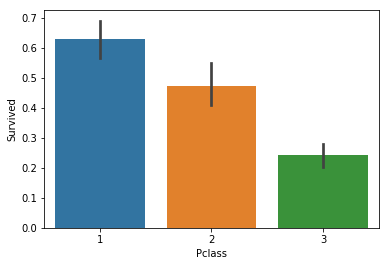

In [40]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

Here we see clearly, that Pclass is contributing to a persons chance of survival

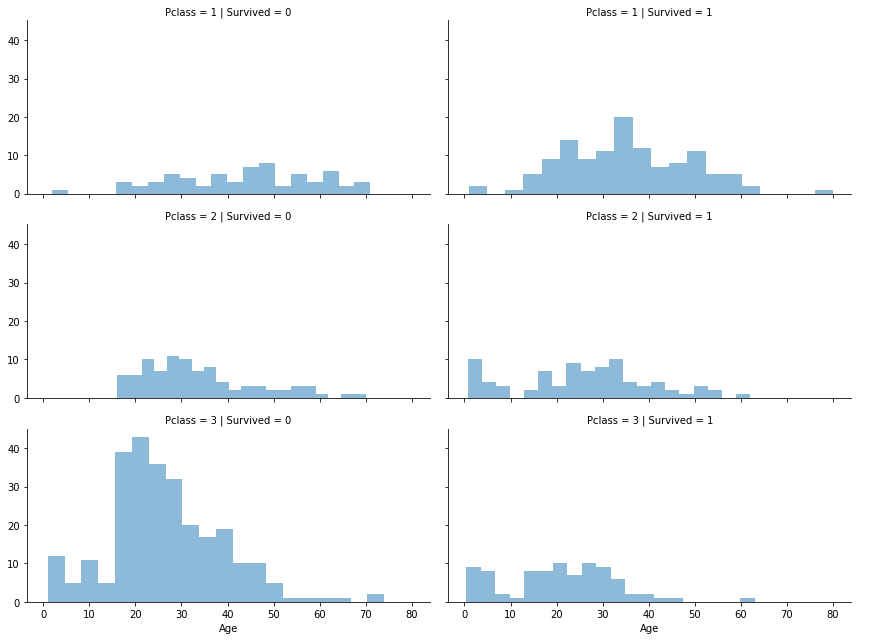

In [41]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=3, aspect=2)
grid.map(plt.hist, 'Age', alpha=0.5, bins=20)
grid.add_legend()

Being along and survival rate has high dependency. Let's investigate it.

In [42]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'is_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'is_alone'] = 1
    dataset['is_alone'] = dataset['is_alone'].astype(int)

In [44]:
train_df.is_alone.value_counts()

1    537
0    354
Name: is_alone, dtype: int64

In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
relatives      891 non-null int64
is_alone       891 non-null int64
dtypes: float64(2), int64(7), object(5)
memory usage: 97.5+ KB


In [66]:
train_df.groupby(['relatives', 'Survived']).PassengerId.count()

relatives  Survived
0          0           374
           1           163
1          0            72
           1            89
2          0            43
           1            59
3          0             8
           1            21
4          0            12
           1             3
5          0            19
           1             3
6          0             8
           1             4
7          0             6
10         0             7
Name: PassengerId, dtype: int64

### Basic_Preprocess

Let's check for irrelevant features first. We can clearly say that PassengerId is irrelevant. So lets drop it.

In [67]:
train_df = train_df.drop(['PassengerId'], axis=1)

### Missing Data in cabin :

We have to deal with Cabin (687), Embarked (2) and Age (177). A cabin number looks like ‘C123’ and the letter refers to the deck.
Therefore we’re going to extract these and create a new feature, that contains a persons deck. 

In [71]:
deck = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'U': 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna('U0')
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile('([a-zA-Z]+)').search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    
train_df.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives,is_alone,Deck
184,1,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4.0,0,2,315153,22.0250,U0,S,2,0,8.0
743,0,3,"McNamee, Mr. Neal",male,24.0,1,0,376566,16.1000,U0,S,1,0,8.0
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,U0,S,2,0,8.0
591,1,1,"Stephenson, Mrs. Walter Bertram (Martha Eustis)",female,52.0,1,0,36947,78.2667,D20,C,1,0,4.0
206,0,3,"Backstrom, Mr. Karl Alfred",male,32.0,1,0,3101278,15.8500,U0,S,1,0,8.0
277,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0000,U0,S,0,1,8.0
34,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,U0,C,1,0,8.0
334,1,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.6500,U0,S,1,0,8.0
218,1,1,"Bazzani, Miss. Albina",female,32.0,0,0,11813,76.2917,D15,C,0,1,4.0
845,0,3,"Abbing, Mr. Anthony",male,42.0,0,0,C.A. 5547,7.5500,U0,S,0,1,8.0
